In [1]:
import os
import sys
os.chdir('../')
new_current_dir = os.getcwd()  # get new current working directory
print("New current directory:", new_current_dir)
sys.path.append('./src/python/')

New current directory: /home/fiftyfour/Documents/NetworkPricingGraphContraction


In [2]:
import pandas as pd


In [4]:
import glob
import itertools
import os
import re





# Define the folder path

# Directory where the files are located
directory = '/home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/'

# Get a list of all files in the directory
files = glob.glob(os.path.join(directory, '*.txt'))

# Create a dictionary to store the pairs
pairs = {}

# Iterate over the files
for file in files:
    # Extract the file name from the full path
    file_name = os.path.basename(file)

    # Split the file name at the underscore
    prefix, suffix = file_name.split('_', 1)

    # If the prefix is already in the dictionary, add the file to the list of pairs
    if prefix in pairs:
        pairs[prefix].append(file)
    # Otherwise, create a new list of pairs for this prefix
    else:
        pairs[prefix] = [file]

# # Print the pairs
# for prefix, files in pairs.items():
#     if len(files) == 2:
#         print(f'Pair: {files[0]} and {files[1]}')
#     else:
#         print(f'No pair found for files with prefix: {prefix}')


Pair: /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/m35-09_my_max_clique_approx_1.txt and /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/m35-09_nx_max_clique_approx.txt
Pair: /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/d40-02_my_max_clique_approx_1.txt and /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/d40-02_nx_max_clique_approx.txt
Pair: /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/g45-01_nx_max_clique_approx.txt and /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/g45-01_my_max_clique_approx_1.txt
Pair: /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/d45-09-01_nx_max_clique_approx.txt and /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/distribution/d45-09-01_my_max_clique_approx_1.txt
Pair: /home/fiftyfour/Documents/NetworkPricingGraphContraction/result/dist

In [34]:
l_res = []
t_res = []
for (my, lit) in pairs.values():
    
    if '_my_' in lit:
        tmp = my
        my = lit
        lit = tmp
        

    data_my = pd.read_csv(my, sep='\t', index_col='iteration')
    data_my.sort_index(inplace=True)
    
    data_nx = pd.read_csv(lit, sep='\t', index_col='iteration')
    data_nx.sort_index(inplace=True)
    
    tmp_l_res = np.mean(list(100*((data_my['lenght']/data_nx['lenght']) -1)))
    tmp_t_res = np.mean(list(100*((data_my['time']/data_nx['time']) -1)))
        
    l_res.append(tmp_l_res)
    t_res.append(tmp_t_res)
    

Text(0.5, 1.0, 'Distribution of max_clique time for NX')

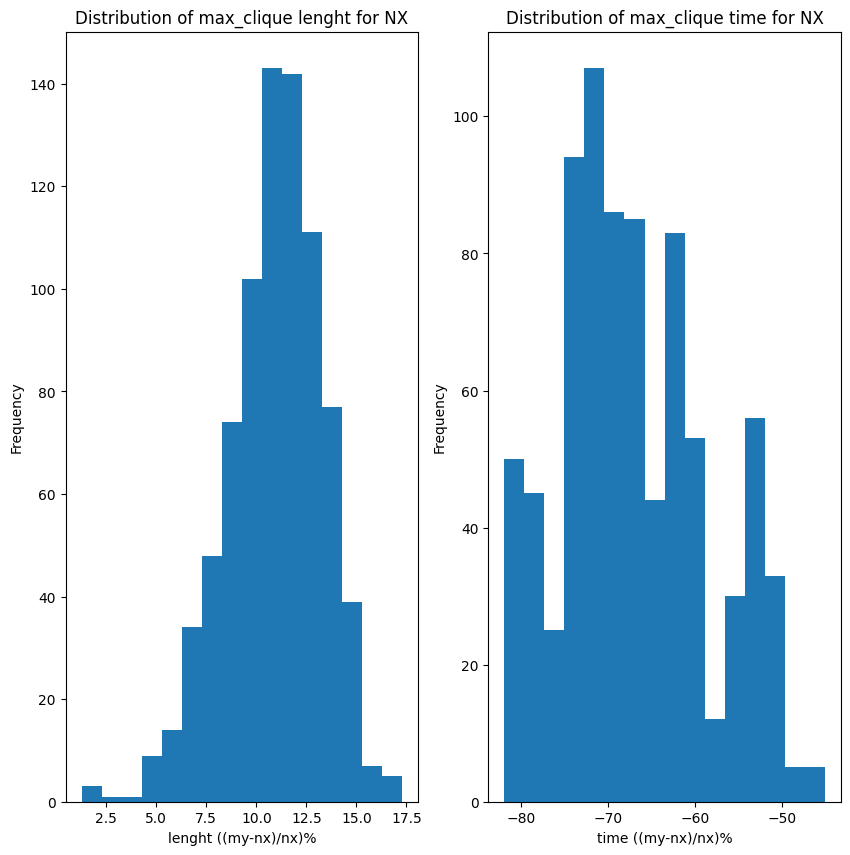

In [35]:
import matplotlib.pyplot as plt
import numpy as np
# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(10,10))

# Plot data on each subplot
bin_edges = np.arange(min(l_res), max(l_res), 1)
axs[0].hist(l_res, bins=bin_edges)
axs[0].set_xlabel('lenght ((my-nx)/nx)%')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of max_clique lenght for NX')
axs[1].hist(t_res, bins='auto')
axs[1].set_xlabel('time ((my-nx)/nx)%')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of max_clique time for NX')